In [174]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, FCC
import awkward as ak
import dask_awkward as dak
import numpy as np
import numba
import sys
ROOT_DIR="/home/prayag/coffeafcc/coffea-fcc-analyses/"
sys.path.append(ROOT_DIR+"analyzers")
import ReconstructedParticle
import fastjet
import hist
from coffea.analysis_tools import PackedSelection

In [2]:
fcc = FCC.get_schema()
events = NanoEventsFactory.from_root(
    '../../data/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root:events',
    schemaclass=fcc,
    # entry_stop=10000,
    metadata={'dataset':'ZH'},
    delayed=True,
    uproot_options={"filter_name": lambda x : "PARAMETERS" not in x}
).events()

/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:226: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:226: UserWarning: Skipping _floatMap as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _floatMap.first as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _floatMap.second as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:226: Us

In [3]:
# #################################
# #Begin the processor definition #
# #################################
# class jetclustering(processor.ProcessorABC):
#     '''
#     Create jets with ee_kt algorithm and form dijets (Higgs --> bb)
#     Create Z candidates from two leptons (Z --> ll)
#     '''
#     def __init__(self, *args, **kwargs):
#         pass

#     def process(self,events):

#         #Create a Packed Selection object to get a cutflow later
#         cut = PackedSelection()
#         cut.add('No cut', dak.ones_like(dak.num(get(events,'ReconstructedParticles','energy'),axis=1),dtype=bool))

#         # Selection 0 : No Cut (example)bb
#         sel0_ocl = cut.cutflow(*cut.names).yieldhist()
#         sel0_events = events

#         # Filter out any event with no reconstructed particles and generate Reconstructed Particle Attributes
#         #ak.mask preserves array length
#         at_least_one_recon = dak.num(get(events,'ReconstructedParticles','energy'), axis=1) > 0
#         good_events = dak.mask(events,at_least_one_recon)
#         cut.add('At least one Reco Particle', at_least_one_recon)

#         # Selection 1 : No Cut and At least one Reco Particle
#         sel1_ocl = cut.cutflow(*cut.names).yieldhist()
#         sel1_events = good_events

#         #Prepare output
#         #Choose the required histograms and their assigned variables to fill
#         names = plot_props.columns.to_list()
#         vars_sel0 = [get(sel0_events,'ReconstructedParticles','energy')]
#         vars_sel1 = [get(sel1_events,'ReconstructedParticles','energy')]

#         Output = {
#             'histograms': {
#                 'sel0':{name:get_1Dhist(name,var,flatten=True) for name,var in zip(names,vars_sel0)},
#                 'sel1':{name:get_1Dhist(name,var,flatten=True) for name,var in zip(names,vars_sel1)}
#             },
#             'cutflow': {
#                 'sel0': {'Onecut':sel0_ocl[0],'Cutflow':sel0_ocl[1],'Labels':sel0_ocl[2]},
#                 'sel1': {'Onecut':sel1_ocl[0],'Cutflow':sel1_ocl[1],'Labels':sel1_ocl[2]}
#             }
#         }
#         return Output

#     def postprocess(self, accumulator):
#         pass


In [4]:
Muons = events.ReconstructedParticles.match_collection(events.Muonidx0)
Z = ReconstructedParticle.resonanceBuilder(Muons, 91.0)
Recoil = ReconstructedParticle.recoilBuilder(Z, 240.0)
z_cuts = PackedSelection()
jet_cuts = PackedSelection()

In [5]:
#Define Selections
sel_p_gt_25_Muons = Muons.p > 25.0

sel_n_e_0_Muons = ak.num(Muons, axis=1) == 0
sel_n_gte_2_Muons = ak.num(Muons, axis=1) >= 2

sel_m_gt_70_Z = Z.m > 70.0
sel_m_lt_100_Z = Z.m < 100.0

sel_p_gt_20_Z = Z.p > 20.0
sel_p_lt_70_Z = Z.p < 70.0

sel_m_gt_120_Recoil = Recoil.m > 120.0
sel_m_lt_140_Recoil = Recoil.m < 140.0

# Add the selections to the cuts Packed Selection
z_cuts.add("p_gt_25_Muons", ak.all(sel_p_gt_25_Muons, axis=1))
z_cuts.add("n_gte_2_Muons", sel_n_gte_2_Muons)
z_cuts.add("m_gt_70_Z", sel_m_gt_70_Z)
z_cuts.add("m_lt_100_Z", sel_m_lt_100_Z)
z_cuts.add("p_gt_20_Z", sel_p_gt_20_Z)
z_cuts.add("p_lt_70_Z", sel_p_lt_70_Z)
z_cuts.add("m_gt_120_Recoil", sel_m_gt_120_Recoil)
z_cuts.add("m_lt_140_Recoil", sel_m_lt_140_Recoil)

In [6]:
# Calculate the final variables
Good_Z = Z[z_cuts.all()]
Good_Recoil = Recoil[z_cuts.all()]

In [196]:
def remove(array, idx):
    index = idx.index
    all_index = ak.local_index(array,axis=1)

    i,a = ak.unzip(ak.cartesian([index[:,np.newaxis] ,all_index], nested=True))
    c = a == i
    d = ak.firsts(c)
    s = dak.sum(d, axis=2)
    kl = s == 1
    
    return array[~kl]

In [198]:
array = events.ReconstructedParticles
idx = events.Muonidx0
f = remove(array, idx)

In [7]:
rps_no_mu = remove(events.)
pseudo_jets = ak.zip(
    {
    'px':rps_no_mu.px,
    'py':rps_no_mu.py,
    'pz':rps_no_mu.pz,
    'E':rps_no_mu.E
    },
    with_name="Momentum4D",
    behavior=fcc.behavior()
)
jetdef = fastjet.JetDefinition0Param(fastjet.ee_kt_algorithm)
# Requirements: 
# [Done] arg_exclusive = 2
# [    ] arg_cut = 2 i.e., N jets for m_exclusive
# [    ] arg_sorted = 0 i.e., p_T ordering
# [    ] arg_recombination = 10 i.e., E0_scheme : Special for FCCAnalyses
jetdef.set_recombination_scheme(0) # E scheme
#jetdef.description()
cluster = fastjet.ClusterSequence(pseudo_jets, jetdef)
jet_constituents = cluster.constituents()
jets = cluster.exclusive_jets(2)
dijets = ak.sum(jets, axis=1)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f674f903a10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

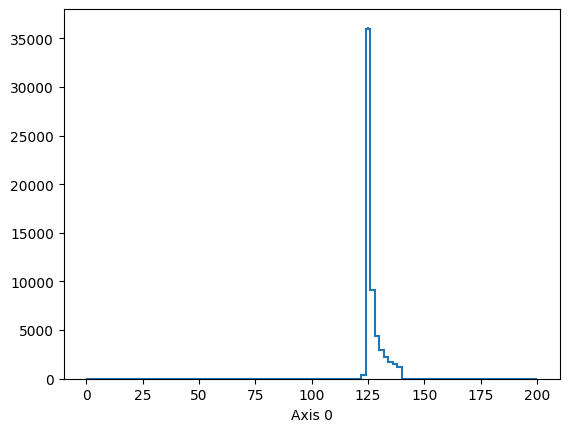

In [8]:
hist.Hist.new.Reg(100,0,200).Double().fill(Good_Recoil.m.compute()).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f673910bce0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

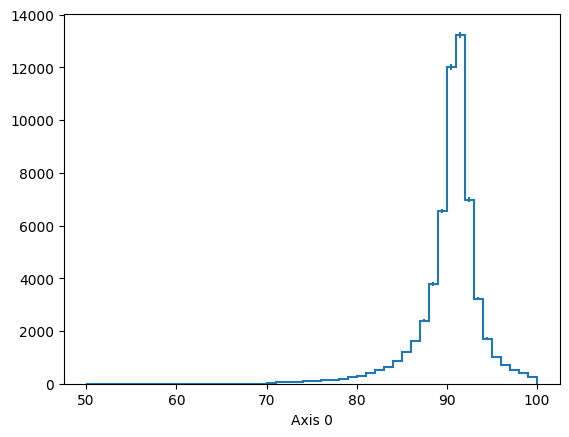

In [9]:
hist.Hist.new.Reg(50,50,100).Double().fill(Good_Z.m.compute()).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f6739143e00>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

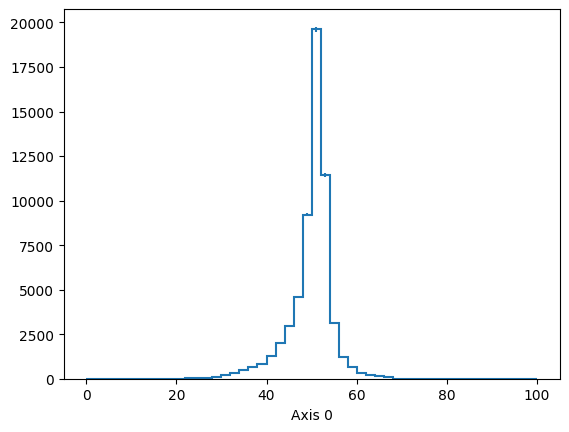

In [10]:
hist.Hist.new.Reg(50,0,100).Double().fill(Good_Z.p.compute()).plot()

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f67395e22d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

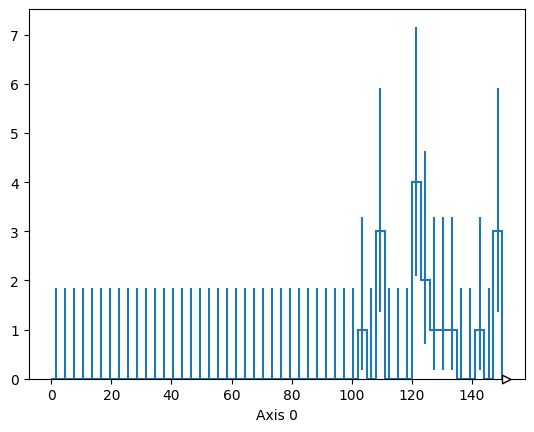

In [11]:
hist.Hist.new.Reg(50,00,150).Double().fill(dijets.m.compute()).plot()